<a href="https://colab.research.google.com/github/hideaki-kyutech/softcomp2023/blob/main/FNN_regression2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# フィードフォワードニューラルネットワークによる回帰

## 準備
### モジュールのインポート
分類の際には使用していなかった
x-y-zの3次元座標空間にプロットするためのAxes3Dモジュールを追加しています。

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # for 3D plot

## 人工データセットの作成
回帰問題の例題として、人工的に生成したデータを回帰に用いる例を示します。
データ数は1000個です。
関数$y=\cos(2x_1)+\cos(3x_2)$に、$-3\leq x_1, x_2\leq 3$の入力を渡すことでデータを作成しています。

In [2]:
# Make the dataset
N = 1000
X = np.random.random((N, 2)) * 6 - 3 # uniformly distributed between (-3, +3)
Y = np.cos(2*X[:,0]) + np.cos(3*X[:,1])

生成したデータをプロットしています。$x_1, x_2$平面に対して$Y$を3次元空間にプロットしています。波打つようなデータの雲が生成されていることが確認できます。

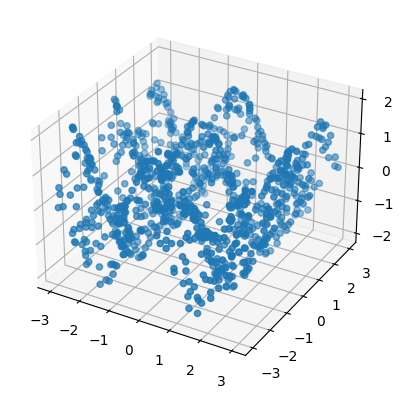

In [4]:
# Plot it
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], Y)
plt.show()

## フィードフォワードニューラルネットワークモデルの構築
入力層は($x_1, x_2$)の2次元入力を受け取るために2、出力層は$Y$を出力するために1と設定しています。
隠れ層は適当に128としています。隠れ層の活性化関数にはReLUを指定しています。

In [5]:
# Build the model: 3-layer MLP (2---128---1)
model = nn.Sequential(
    nn.Linear(2, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
)

## ロスとオプティマイザーの設定
回帰問題なので、ロスはMSE(Mean Square Error: 平均二乗誤差)を使います。
また、最適化方法としてAdamaを使用しており、学習率を0.01に設定しています。

In [6]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## 学習（パラメータの更新）
エポック数（学習回数）は1000を指定しています。ここでは、学習を行う関数`full_gd`を作成し、その後それを呼び出す形で実行しています。

In [7]:
# Train the model
def full_gd(model, criterion, optimizer, X_train, y_train, epochs=1000):
  # Stuff to store
  train_losses = np.zeros(epochs)

  for it in range(epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = loss.item()

    if (it + 1) % 50 == 0:
      print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}')

  return train_losses

X_train = torch.from_numpy(X.astype(np.float32))
y_train = torch.from_numpy(Y.astype(np.float32).reshape(-1, 1))
train_losses = full_gd(model, criterion, optimizer, X_train, y_train)

Epoch 50/1000, Train Loss: 0.7734
Epoch 100/1000, Train Loss: 0.4275
Epoch 150/1000, Train Loss: 0.3497
Epoch 200/1000, Train Loss: 0.2897
Epoch 250/1000, Train Loss: 0.1828
Epoch 300/1000, Train Loss: 0.0586
Epoch 350/1000, Train Loss: 0.0164
Epoch 400/1000, Train Loss: 0.0091
Epoch 450/1000, Train Loss: 0.0052
Epoch 500/1000, Train Loss: 0.0043
Epoch 550/1000, Train Loss: 0.0122
Epoch 600/1000, Train Loss: 0.0034
Epoch 650/1000, Train Loss: 0.0031
Epoch 700/1000, Train Loss: 0.0030
Epoch 750/1000, Train Loss: 0.0032
Epoch 800/1000, Train Loss: 0.0028
Epoch 850/1000, Train Loss: 0.0026
Epoch 900/1000, Train Loss: 0.0049
Epoch 950/1000, Train Loss: 0.0026
Epoch 1000/1000, Train Loss: 0.0031


## 誤差曲線のプロット

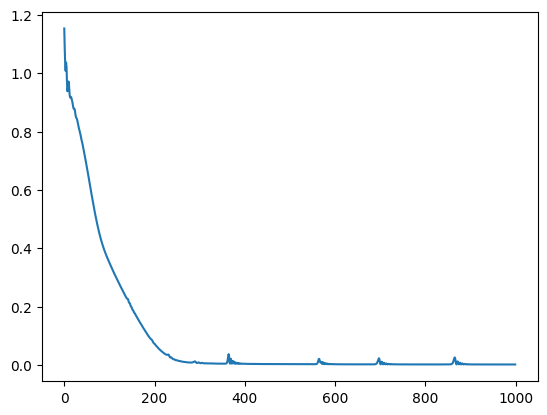

In [7]:
plt.plot(train_losses)

## 学習後の回帰モデルの表示
学習後の回帰モデルに入力を与えて、どのような近似曲面が得られているかを確認します。

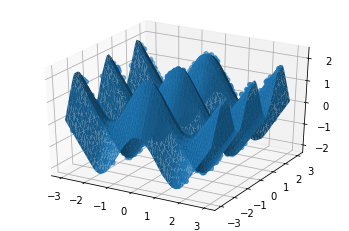

In [ ]:
# Plot the prediction surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], Y)

# surface plot
with torch.no_grad():
  line = np.linspace(-3, 3, 50)
  xx, yy = np.meshgrid(line, line)
  Xgrid = np.vstack((xx.flatten(), yy.flatten())).T
  Xgrid_torch = torch.from_numpy(Xgrid.astype(np.float32))
  Yhat = model(Xgrid_torch).numpy().flatten()
  ax.plot_trisurf(Xgrid[:,0], Xgrid[:,1], Yhat, linewidth=0.2, antialiased=True)
  plt.show()

学習した範囲は$-3\leq x_1, x_2 \leq 3$でしたが、その外側では近似曲面はどうなっているかを確認します。ここでは、$-5\leq x_1, x_2 \leq 5$までの近似局面を描いて結果を確認します。描画結果から、外側では単調に曲面が延伸している結果となります。この結果から、ニューラルネットワークで学習データの外側の回帰結果は全く妥当ではない結果が得られることがわかります。

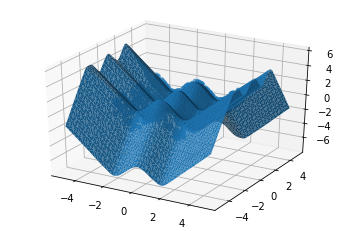

In [ ]:
# Can it extrapolate?
# Plot the prediction surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], Y)

# surface plot
with torch.no_grad():
  line = np.linspace(-5, 5, 50)
  xx, yy = np.meshgrid(line, line)
  Xgrid = np.vstack((xx.flatten(), yy.flatten())).T
  Xgrid_torch = torch.from_numpy(Xgrid.astype(np.float32))
  Yhat = model(Xgrid_torch).numpy().flatten()
  ax.plot_trisurf(Xgrid[:,0], Xgrid[:,1], Yhat, linewidth=0.2, antialiased=True)
  plt.show()